In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test2 import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper Functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
#ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

In [5]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [6]:
seed = 42  # choose any integer
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
np.random.seed(seed)
random.seed(seed)

In [7]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [8]:
def reset_seeds(seed=42):
    import torch, numpy as np, random
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Case 1: Original model
MSELoss, Standardization, Patience = 30

In [9]:
reset_seeds(42)

In [10]:
model1 = FCNN(config=config)
model1

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [11]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [12]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model1, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model1.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 7.499e-01, Val Loss: 7.961e-01, Val R²: 0.0706, Epoch Time: 12.42s
Model saved at epoch 1
Epoch 2, Train Loss: 5.860e-01, Val Loss: 5.333e-01, Val R²: 0.3653, Epoch Time: 12.00s
Model saved at epoch 2
Epoch 3, Train Loss: 5.554e-01, Val Loss: 5.334e-01, Val R²: 0.3105, Epoch Time: 11.98s
Model saved at epoch 3
Epoch 4, Train Loss: 5.308e-01, Val Loss: 5.193e-01, Val R²: 0.3748, Epoch Time: 12.04s
Model saved at epoch 4
Epoch 5, Train Loss: 5.200e-01, Val Loss: 4.869e-01, Val R²: 0.4046, Epoch Time: 12.15s
Model saved at epoch 5
Epoch 6, Train Loss: 5.133e-01, Val Loss: 4.933e-01, Val R²: 0.3824, Epoch Time: 12.18s
Model saved at epoch 6
Epoch 7, Train Loss: 5.105e-01, Val Loss: 4.784e-01, Val R²: 0.3993, Epoch Time: 12.33s
Model saved at epoch 7
Epoch 8, Train Loss: 4.905e-01, Val Loss: 4.763e-01, Val R²: 0.4161, Epoch Time: 12.40s
Model saved at epoch 8
Epoch 9, Train Loss: 4.995e-01, Val Loss: 5.195e-01, Val R²: 0.3823, Epoch Time: 12

In [13]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model1, device, test_loader, HF_test, './model1.pth')
sgs_pred

Loaded model parameters from ./model1.pth


array([[[ 2.4441528e-01,  4.3714532e-01,  2.6353565e-01, ...,
          6.9440597e-01,  7.0481145e-01,  6.8767059e-01],
        [-7.2129250e-01, -5.8962524e-01, -7.0739734e-01, ...,
          1.0008814e+00,  9.6463275e-01,  9.7112155e-01],
        [-7.3036891e-01, -6.7874885e-01, -7.2693807e-01, ...,
          1.2608501e+00,  1.2725544e+00,  1.3108081e+00],
        ...,
        [ 6.7777693e-01,  6.0527009e-01,  5.9357953e-01, ...,
          4.8916057e-01,  6.3976574e-01,  4.7602943e-01],
        [ 7.4821764e-01,  6.6587657e-01,  6.4622289e-01, ...,
          4.0707725e-01,  5.4820120e-01,  3.9087057e-01],
        [ 9.5444834e-01,  8.4637278e-01,  8.2244271e-01, ...,
          4.1273096e-01,  5.5699831e-01,  3.9762825e-01]],

       [[ 1.2248592e-02, -8.1584431e-02, -3.0811230e-02, ...,
         -1.7606416e-01, -9.9879682e-02, -1.5776703e-01],
        [-1.5070173e-01, -2.4194933e-01, -1.9253682e-01, ...,
         -2.9945180e-01, -2.2784419e-01, -2.7872884e-01],
        [-6.1041135e-02, 

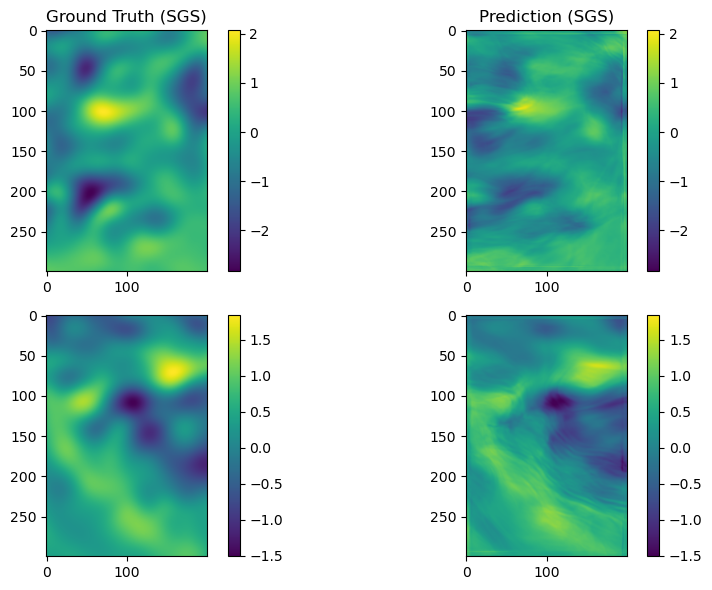

In [14]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

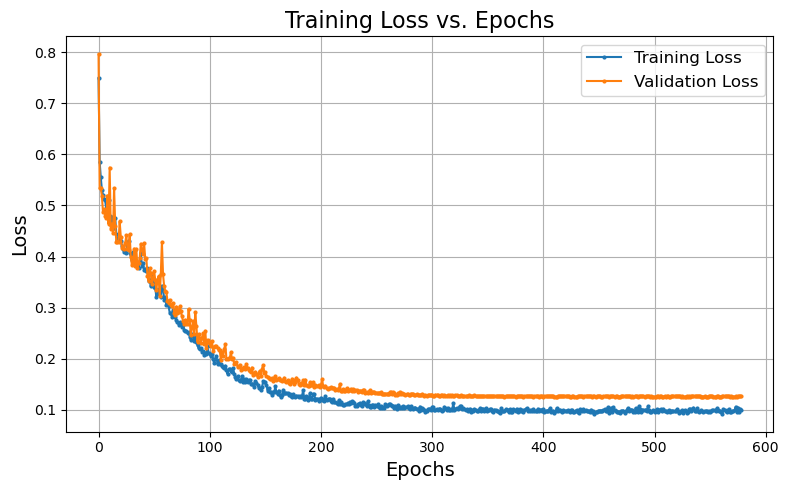

In [15]:
plot_train_val_losses(train_losses, val_losses)

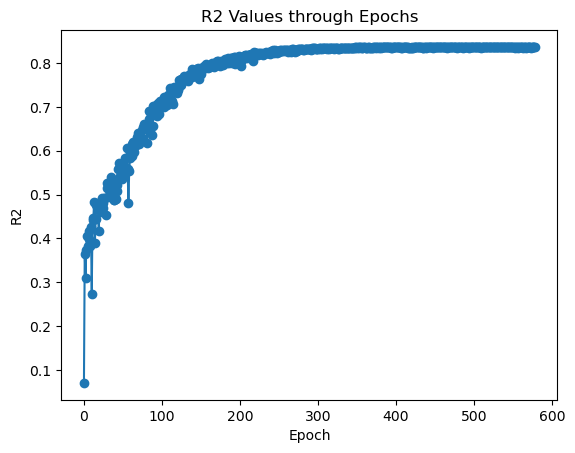

In [16]:
# x-axis = index positions (0, 1, 2, ...)
x = np.arange(len(r2_vals))

# Plot
plt.plot(x, r2_vals, marker='o')
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.title("R2 Values through Epochs")
plt.show()

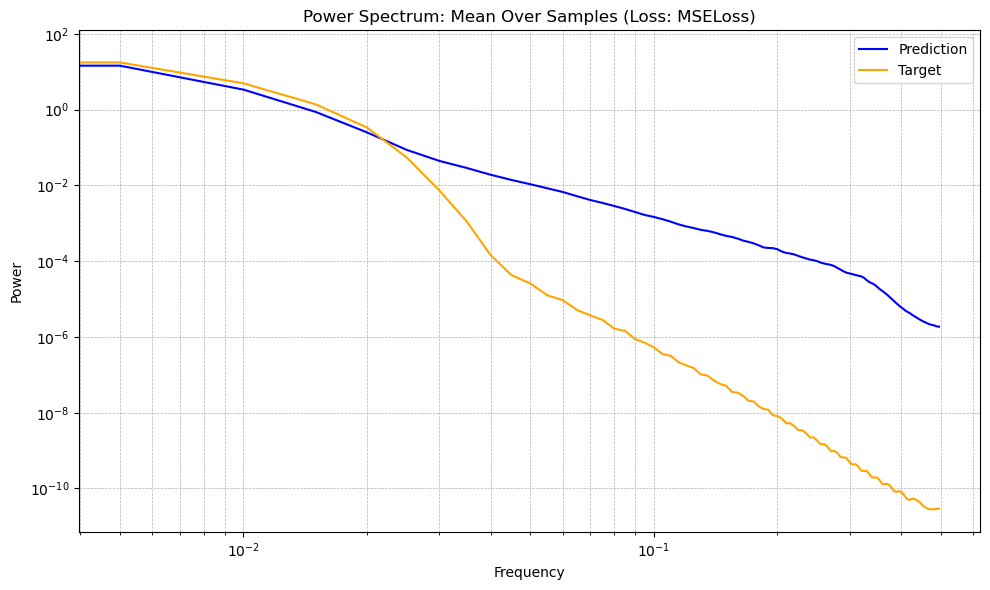

In [17]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [18]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.13092097640037537
Pearson correlation coefficient is 0.9286974791444391
r2 is 0.8620995283126831
ESR first exceeds half at None


In [19]:
r2_scores_m1 = r2_per_sample(HF_test, sgs_pred)
r2_scores_m1

array([0.70436668, 0.88604653, 0.7856223 , 0.82140255, 0.87581384,
       0.79562861, 0.77053869, 0.80609798, 0.86055964, 0.77115005,
       0.9024148 , 0.7739259 , 0.89295101, 0.56946594, 0.86314809,
       0.7547456 , 0.88276452, 0.88083565, 0.73056036, 0.91649097,
       0.82086951, 0.86747336, 0.47761369, 0.8606829 , 0.78232992,
       0.82245845, 0.80251592, 0.84611028, 0.58425194, 0.86076075,
       0.84787464, 0.6670624 , 0.65002447, 0.75795203, 0.29631442,
       0.89109021, 0.87136728, 0.93056679, 0.79596567, 0.82471812,
       0.86633384, 0.76546204, 0.85439962, 0.95283937, 0.88624555,
       0.82835627, 0.88825607, 0.7725426 , 0.82901096, 0.8371141 ,
       0.87758952, 0.7726261 , 0.85731244, 0.77751917, 0.85873574,
       0.5781157 , 0.79790235, 0.83454114, 0.91288191, 0.75022089,
       0.83278823, 0.84637934, 0.83442634, 0.88480461, 0.81732333,
       0.87693578, 0.9304893 , 0.89751184, 0.79480904, 0.78234524,
       0.85963941, 0.88768882, 0.77228403, 0.90141916, 0.88022

# Case 2: Model re-initialized
MSELoss, Standardization, Patience = 30

In [20]:
reset_seeds(42)
model2 = FCNN(config=config)
model2

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [21]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model2, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model2.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 7.499e-01, Val Loss: 7.961e-01, Val R²: 0.0706, Epoch Time: 12.59s
Model saved at epoch 1
Epoch 2, Train Loss: 5.860e-01, Val Loss: 5.333e-01, Val R²: 0.3653, Epoch Time: 12.70s
Model saved at epoch 2
Epoch 3, Train Loss: 5.554e-01, Val Loss: 5.334e-01, Val R²: 0.3105, Epoch Time: 12.62s
Model saved at epoch 3
Epoch 4, Train Loss: 5.307e-01, Val Loss: 5.194e-01, Val R²: 0.3747, Epoch Time: 12.62s
Model saved at epoch 4
Epoch 5, Train Loss: 5.199e-01, Val Loss: 4.848e-01, Val R²: 0.4098, Epoch Time: 12.55s
Model saved at epoch 5
Epoch 6, Train Loss: 5.130e-01, Val Loss: 4.919e-01, Val R²: 0.3841, Epoch Time: 12.47s
Model saved at epoch 6
Epoch 7, Train Loss: 5.098e-01, Val Loss: 4.774e-01, Val R²: 0.4016, Epoch Time: 12.47s
Model saved at epoch 7
Epoch 8, Train Loss: 4.908e-01, Val Loss: 4.799e-01, Val R²: 0.4115, Epoch Time: 12.49s
Model saved at epoch 8
Epoch 9, Train Loss: 4.991e-01, Val Loss: 5.072e-01, Val R²: 0.3945, Epoch Time: 12

In [22]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model2, device, test_loader, HF_test, './model2.pth')
sgs_pred

Loaded model parameters from ./model2.pth


array([[[ 2.72373557e-01,  5.19845128e-01,  3.17149609e-01, ...,
          5.42565227e-01,  7.12777674e-01,  5.68622351e-01],
        [-1.20112568e-01, -4.65577766e-02, -1.22058839e-01, ...,
          1.98565513e-01,  3.52053165e-01,  2.08777606e-01],
        [-3.44678015e-01, -3.06500942e-01, -3.55849892e-01, ...,
          5.66135168e-01,  6.76779747e-01,  4.98045713e-01],
        ...,
        [ 5.47940135e-01,  3.93479586e-01,  4.27437127e-01, ...,
          7.15800583e-01,  7.70951509e-01,  6.37624443e-01],
        [ 8.25847268e-01,  7.85039842e-01,  7.39570677e-01, ...,
          7.37564981e-01,  8.29185545e-01,  6.76451206e-01],
        [ 8.13792467e-01,  7.12433875e-01,  7.18467593e-01, ...,
          6.40129268e-01,  7.42032230e-01,  6.03455901e-01]],

       [[ 1.70284975e-03, -2.53692195e-02, -9.14749503e-02, ...,
         -1.16503716e-01, -6.29928056e-03, -1.60288498e-01],
        [-1.02324128e-01, -1.22379810e-01, -1.94955766e-01, ...,
         -6.88502938e-02,  5.55087738e

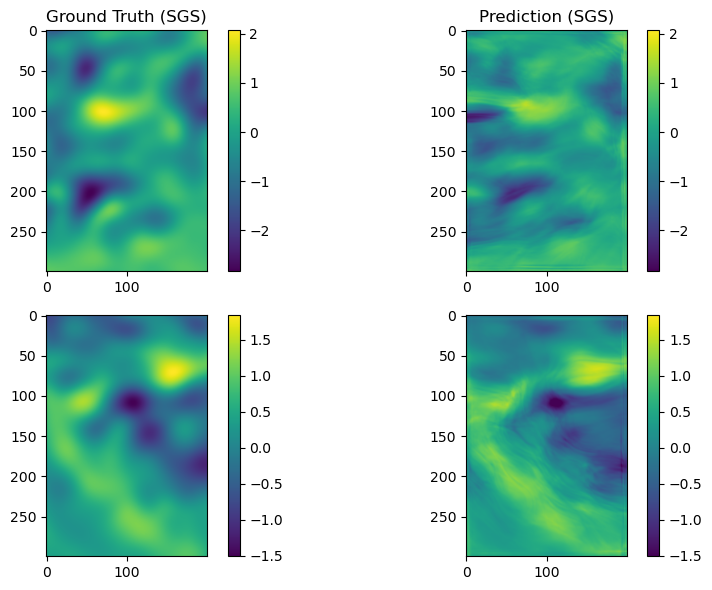

In [23]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

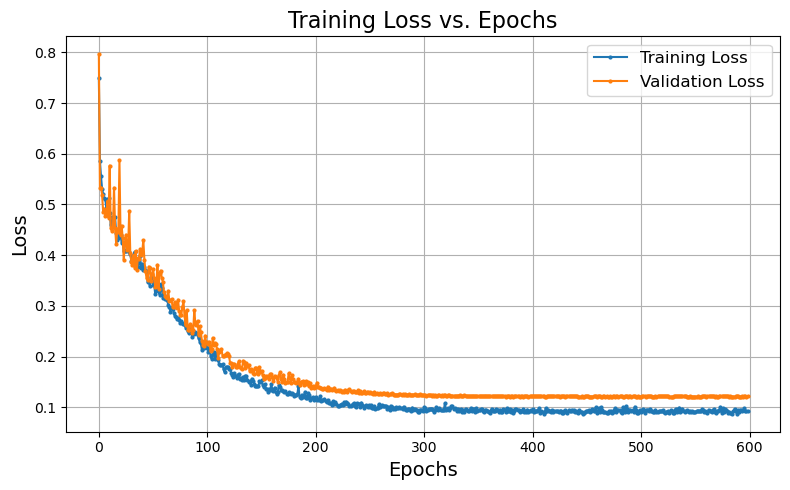

In [24]:
plot_train_val_losses(train_losses, val_losses)

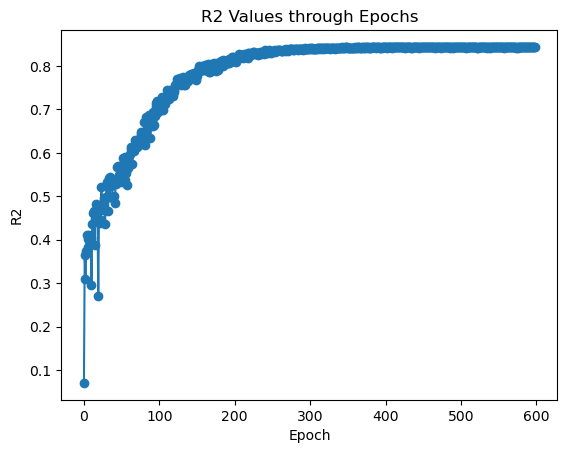

In [25]:
# x-axis = index positions (0, 1, 2, ...)
x = np.arange(len(r2_vals))

# Plot
plt.plot(x, r2_vals, marker='o')
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.title("R2 Values through Epochs")
plt.show()

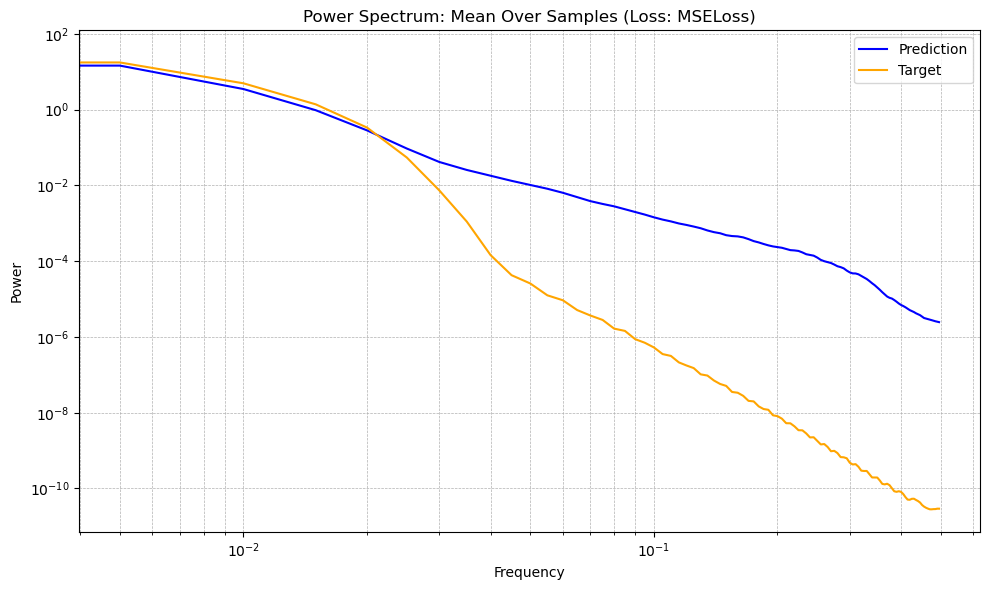

In [26]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [27]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.1194576546549797
Pearson correlation coefficient is 0.9352637809462231
r2 is 0.8741739988327026
ESR first exceeds half at None


In [28]:
r2_scores_m2 = r2_per_sample(HF_test, sgs_pred)
r2_scores_m2

array([0.63363469, 0.90310216, 0.79537183, 0.84031314, 0.88770962,
       0.82645726, 0.82253361, 0.81938195, 0.88827139, 0.80423617,
       0.9238798 , 0.82003444, 0.86264467, 0.63897383, 0.86044407,
       0.81755209, 0.87787068, 0.88833058, 0.74865544, 0.9226594 ,
       0.81899703, 0.89528424, 0.47344482, 0.85102397, 0.73549032,
       0.86771727, 0.80455792, 0.83995759, 0.61004043, 0.86826611,
       0.87860131, 0.74358487, 0.65481037, 0.75247002, 0.69564605,
       0.91347432, 0.87287784, 0.91962755, 0.785743  , 0.8429153 ,
       0.84983915, 0.80083394, 0.87661594, 0.9539724 , 0.89750773,
       0.86165869, 0.91144478, 0.83682877, 0.84761477, 0.84222126,
       0.89824897, 0.79308462, 0.88426608, 0.77317929, 0.86703306,
       0.66141021, 0.79592651, 0.85229969, 0.91435933, 0.73357534,
       0.85439235, 0.8654871 , 0.85695124, 0.83086979, 0.82658243,
       0.89147055, 0.93217039, 0.90205032, 0.8029694 , 0.77603465,
       0.8688271 , 0.88914418, 0.81291234, 0.89147007, 0.88172

# Case 3: Model not re-initialized
MSELoss, Standardization, Patience = 30

In [29]:
# NO MODEL RE-INIT

#reset_seeds(42)
#model3 = FCNN(config=config)
#model3

In [31]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model2, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model3.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 3.859e-01, Val Loss: 6.788e-01, Val R²: 0.2284, Epoch Time: 12.55s
Model saved at epoch 1
Epoch 2, Train Loss: 3.062e-01, Val Loss: 2.953e-01, Val R²: 0.6300, Epoch Time: 12.66s
Model saved at epoch 2
Epoch 3, Train Loss: 2.750e-01, Val Loss: 2.645e-01, Val R²: 0.6674, Epoch Time: 12.77s
Model saved at epoch 3
Epoch 4, Train Loss: 2.442e-01, Val Loss: 2.454e-01, Val R²: 0.6912, Epoch Time: 12.58s
Model saved at epoch 4
Epoch 5, Train Loss: 2.486e-01, Val Loss: 3.129e-01, Val R²: 0.6305, Epoch Time: 12.48s
Model saved at epoch 5
Epoch 6, Train Loss: 2.422e-01, Val Loss: 2.628e-01, Val R²: 0.6532, Epoch Time: 12.44s
Model saved at epoch 6
Epoch 7, Train Loss: 2.106e-01, Val Loss: 2.846e-01, Val R²: 0.6544, Epoch Time: 12.46s
Model saved at epoch 7
Epoch 8, Train Loss: 2.306e-01, Val Loss: 2.111e-01, Val R²: 0.7278, Epoch Time: 12.48s
Model saved at epoch 8
Epoch 9, Train Loss: 1.977e-01, Val Loss: 2.051e-01, Val R²: 0.7342, Epoch Time: 12

In [32]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model2, device, test_loader, HF_test, './model3.pth')
sgs_pred

Loaded model parameters from ./model3.pth


array([[[-0.16289987,  0.0127257 , -0.2782724 , ...,  0.39202598,
          0.5592513 ,  0.47655308],
        [-0.17023066, -0.02479601, -0.29481503, ...,  0.5584875 ,
          0.7288776 ,  0.6010484 ],
        [-0.27127424, -0.12240157, -0.3821897 , ...,  0.66285694,
          0.82832706,  0.7010888 ],
        ...,
        [ 0.610069  ,  0.51554924,  0.4855641 , ...,  0.8581184 ,
          0.91134393,  0.69954824],
        [ 0.7526125 ,  0.6710476 ,  0.71816546, ...,  0.8087051 ,
          0.8611307 ,  0.6552174 ],
        [ 0.687238  ,  0.60826004,  0.61052096, ...,  0.75798553,
          0.8035716 ,  0.59389114]],

       [[-0.02763703,  0.12074335, -0.14229198, ...,  0.08966926,
          0.05394979,  0.04645071],
        [ 0.01896179,  0.16419332, -0.13433556, ...,  0.05812956,
          0.06663464,  0.02161429],
        [-0.12479854,  0.04555344, -0.24276897, ..., -0.12774457,
         -0.13439511, -0.17919908],
        ...,
        [ 0.6583234 ,  0.66234744,  0.7791044 , ...,  

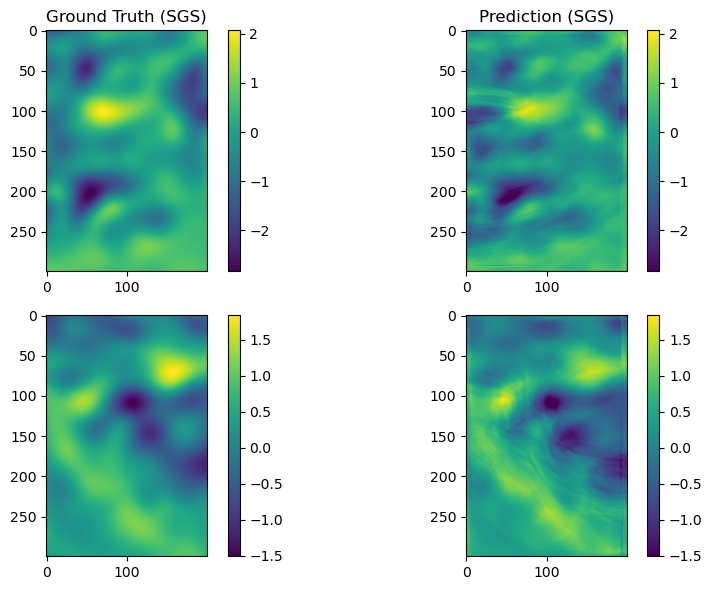

In [33]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

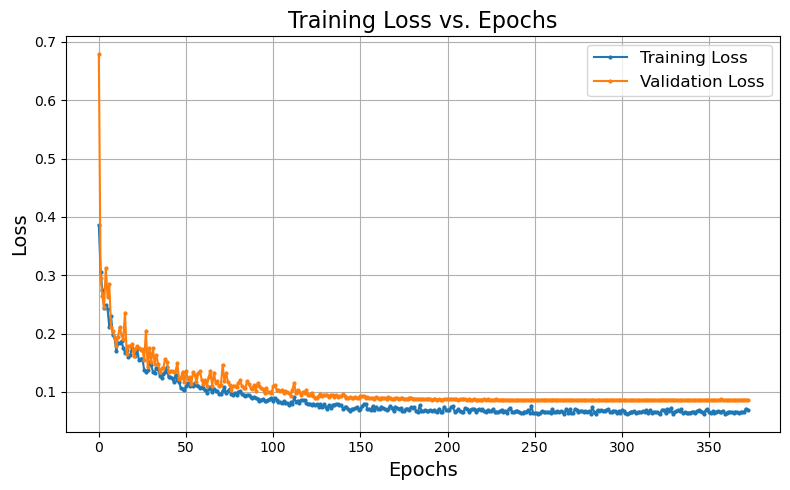

In [34]:
plot_train_val_losses(train_losses, val_losses)

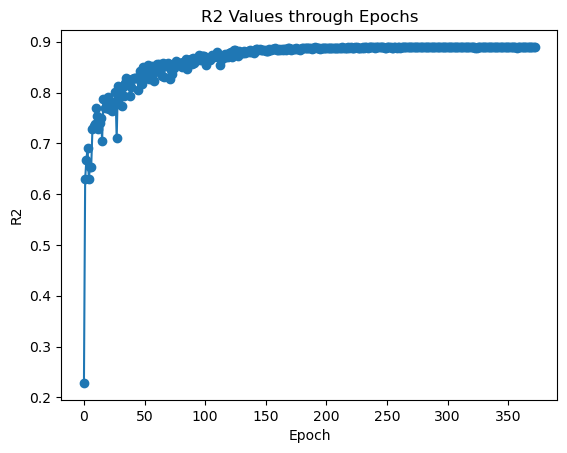

In [35]:
# x-axis = index positions (0, 1, 2, ...)
x = np.arange(len(r2_vals))

# Plot
plt.plot(x, r2_vals, marker='o')
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.title("R2 Values through Epochs")
plt.show()

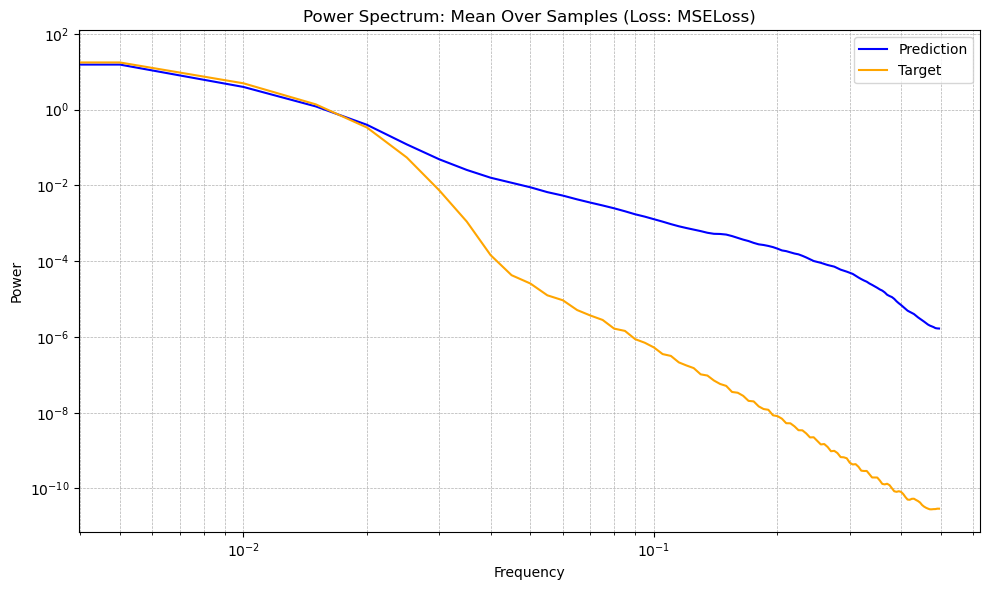

In [36]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [37]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.08323176950216293
Pearson correlation coefficient is 0.9551924282176002
r2 is 0.9123311042785645
ESR first exceeds half at None


In [38]:
r2_scores_m3 = r2_per_sample(HF_test, sgs_pred)
r2_scores_m3

array([0.78016162, 0.90997142, 0.84851384, 0.89121544, 0.92054033,
       0.8475759 , 0.87608081, 0.8481313 , 0.91677761, 0.83406079,
       0.95188606, 0.91340733, 0.92199087, 0.71271288, 0.91786027,
       0.89365131, 0.91049534, 0.94715434, 0.82405221, 0.9461782 ,
       0.87365395, 0.92805874, 0.67315346, 0.92409658, 0.80168527,
       0.89146703, 0.85043114, 0.8879686 , 0.78470778, 0.91472864,
       0.89934337, 0.86330217, 0.81444389, 0.80287004, 0.72468817,
       0.95017934, 0.92785859, 0.94125223, 0.85580158, 0.88930196,
       0.90427101, 0.86644882, 0.93209493, 0.96460742, 0.93890798,
       0.90201497, 0.93106008, 0.85530853, 0.89393216, 0.9093923 ,
       0.93054968, 0.88734442, 0.92614073, 0.83694881, 0.90374517,
       0.84122956, 0.86980414, 0.88199729, 0.93722785, 0.78749651,
       0.90343732, 0.91496271, 0.89057863, 0.90823114, 0.89065295,
       0.92927939, 0.94858462, 0.92596811, 0.83787954, 0.85406977,
       0.930103  , 0.92905414, 0.88625866, 0.91670907, 0.91405

# Comparison

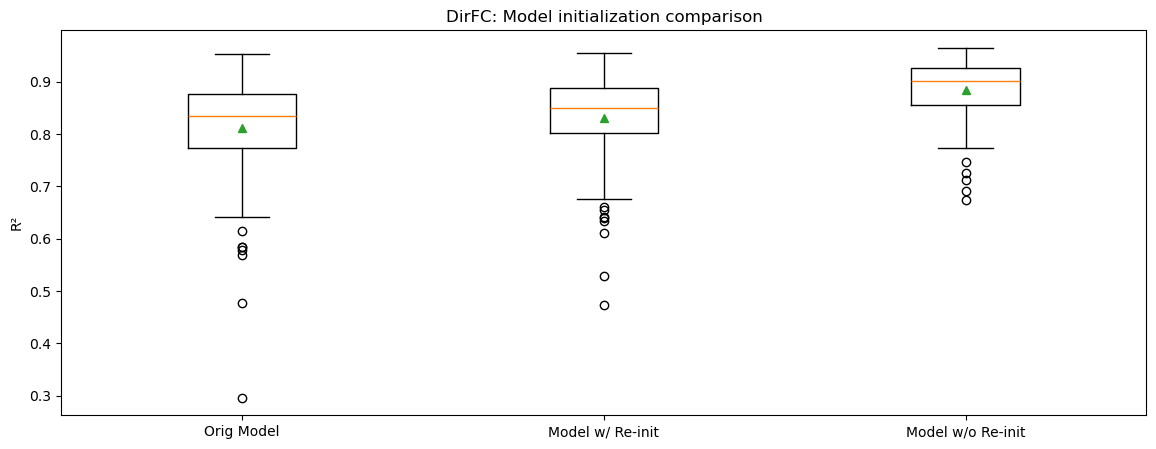

In [40]:
data = [r2_scores_m1, r2_scores_m2, r2_scores_m3]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True, showmeans=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3], ["Orig Model", "Model w/ Re-init", "Model w/o Re-init"])  # label each box
plt.ylabel("R²")
plt.title("DirFC: Model initialization comparison")
plt.show()